# Number recognition

## Model generation

In [19]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.utils import to_categorical

import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
(X_train,Y_train),(X_test,Y_test) = mnist.load_data()
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

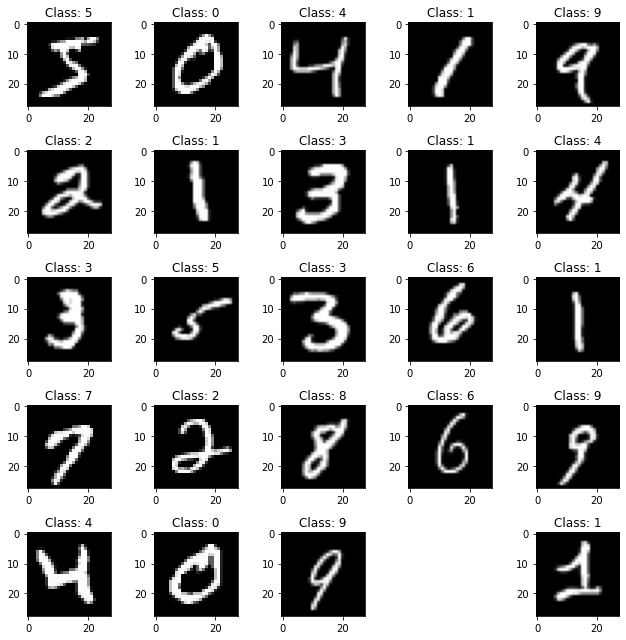

In [21]:
plt.figure(figsize=(9,9))
for idx in range(25):
  plt.subplot(5,5, idx+1)
  plt.imshow(X_train[idx], cmap='gray')
  plt.title('Class: {}'.format(Y_train[idx]))

  plt.tight_layout()

In [22]:
X_train.shape

(60000, 28, 28)

In [23]:
img_rows, img_cols = X_train.shape[1], X_train.shape[2]

X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

input_shape = (784)

In [24]:
X_train.shape, X_test.shape, input_shape

((60000, 784), (10000, 784), 784)

In [25]:
if np.max(X_train) >1: X_train = X_train / 255
if np.max(X_test) >1: X_test = X_test / 255

In [26]:
if len(Y_train.shape)==1:
  num_classes = len(set(Y_train))
  Y_train = to_categorical(Y_train, num_classes)
  Y_test = to_categorical(Y_test, num_classes)

Y_train.shape

(60000, 10)

In [29]:
model = Sequential([
    Dense(512, input_shape=(784, ), activation='relu'),
    Dropout(0.2),
    
    Dense(512, activation='relu'),
    Dropout(0.2),

    Dense(num_classes, activation='softmax'),
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [30]:
model.fit(
  X_train, Y_train,
  batch_size=128,
  epochs=20,
  verbose=2,
  validation_data=(X_test,Y_test)
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 - 13s - loss: 0.2469 - accuracy: 0.9261 - val_loss: 0.1052 - val_accuracy: 0.9673
Epoch 2/20
60000/60000 - 13s - loss: 0.0995 - accuracy: 0.9699 - val_loss: 0.0767 - val_accuracy: 0.9749
Epoch 3/20
60000/60000 - 12s - loss: 0.0717 - accuracy: 0.9778 - val_loss: 0.0705 - val_accuracy: 0.9795
Epoch 4/20
60000/60000 - 13s - loss: 0.0568 - accuracy: 0.9818 - val_loss: 0.0622 - val_accuracy: 0.9811
Epoch 5/20
60000/60000 - 14s - loss: 0.0462 - accuracy: 0.9850 - val_loss: 0.0688 - val_accuracy: 0.9787
Epoch 6/20
60000/60000 - 12s - loss: 0.0405 - accuracy: 0.9863 - val_loss: 0.0709 - val_accuracy: 0.9802
Epoch 7/20
60000/60000 - 13s - loss: 0.0334 - accuracy: 0.9887 - val_loss: 0.0681 - val_accuracy: 0.9796
Epoch 8/20
60000/60000 - 13s - loss: 0.0305 - accuracy: 0.9904 - val_loss: 0.0667 - val_accuracy: 0.9811
Epoch 9/20
60000/60000 - 13s - loss: 0.0235 - accuracy: 0.9918 - val_loss: 0.0718 - val_accuracy: 0.9827
Epoch

In [31]:
score = model.evaluate(X_test, Y_test, verbose=0)
score

[0.07484039724187128, 0.9834]

In [32]:
model.save('number_recognition_model.h5')

## Data testing

In [33]:
from PIL import Image
from math import floor, ceil
from matplotlib import cm


In [36]:
def predict(img):
  global model
  res = model.predict([img])[0]
  return np.argmax(res), max(res)

def process_img(path_to_img):
  image = Image.open(path_to_img)
  image = image.convert('L')
  image = np.array(image)
  image = image / 255
  new_image = np.zeros((28, 28))
  old_image_rows, old_image_cols = image.shape
  new_image[14- floor(old_image_rows/2):14 + ceil(old_image_rows/2), 14- floor(old_image_cols/2):14 + ceil(old_image_cols/2)] = image
  new_image = new_image.reshape(1, 784)
  new_image[new_image<0.1] = 0
  return new_image

In [37]:
predict(process_img("digits_for_testing/2.png"))

(2, 0.99934644)

## Model explaining

In [38]:
import shap
import numpy as np


In [62]:
(X_train,_),(_,_) = mnist.load_data()
if np.max(X_train) >1: X_train = X_train / 255
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]
print(background.shape)
processed_background = background.reshape(-1, 784)
processed_background.shape

(100, 28, 28)


(100, 784)

IndexError: tuple index out of range

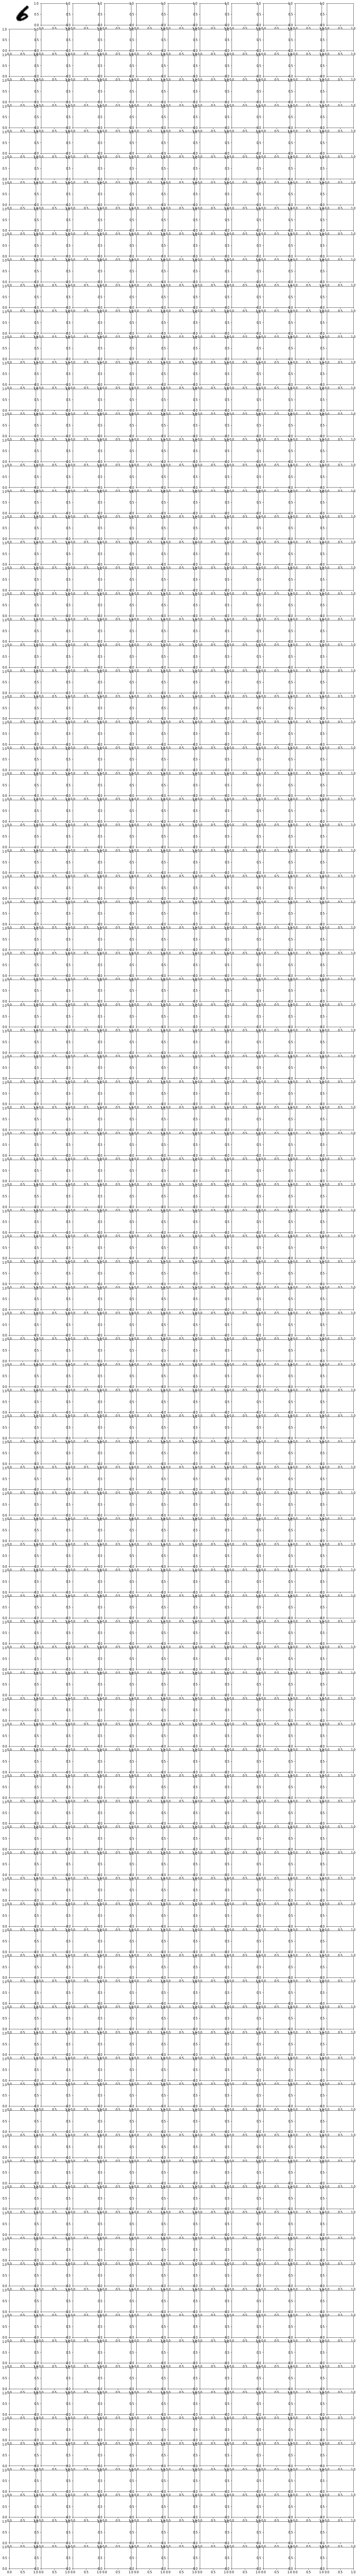

In [63]:
e = shap.DeepExplainer(model, processed_background)
shap_values = e.shap_values(processed_background, check_additivity=False)
shap.image_plot(shap_values, -background)